In [1]:
import os
from processing import msevn
import pandas as pd
import scipy
import re

root = './matlab/output'

In [2]:
normal_distr = scipy.stats.norm(loc=83, scale=11)

get_rel_amp = lambda x: normal_distr.pdf(x) / normal_distr.pdf(83)

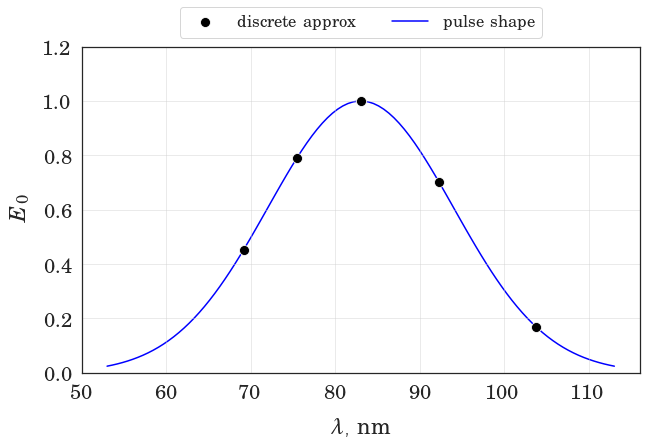

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

msevn.configure_mpl()

#sns.histplot(x=[830 / i for i in range(8, 13)], y=[get_rel_amp(830 / i) for i in range(8, 13)])
t = 30
x = np.linspace(83 - t, 83 + t, 100)

fig, ax = plt.subplots(figsize=(10, 6))
wls = [830 / i for i in range(8, 13)]

for wl in wls:
    if wl == wls[0]:
        sns.scatterplot(x=[wl], y=[get_rel_amp(wl)], color='black', ax=ax, s=100, marker='o', label=r'$\rm{discrete}$ $\rm{approx}$')
    else:
        sns.scatterplot(x=[wl], y=[get_rel_amp(wl)], color='black', ax=ax, s=100, marker='o')

sns.lineplot(x=x, y=get_rel_amp(x), zorder=-1, ax=ax, color='blue', label=r'$\rm{pulse}$ $\rm{shape}$')
ax.set_xlabel(r'$\lambda$, $\rm{nm}$', labelpad=15)
ax.set_ylabel(r'$E_0$', labelpad=15)
ax.set_ylim(0, 1.2)

lgd = ax.legend(loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=18)

#fig.savefig(f'../tex/components/img/celes/wavepacket8..12_rad.pdf', bbox_inches='tight')

In [14]:
def get_value(x: str, field: str = 'gap') -> float:

    val = x.split(f'{field}_')[0].split('_')[-1]
    return float(val)

# ------------------------- #

def process_files() -> dict:

    files = {}

    for k in os.listdir(root):
        if not k.endswith('.mat'):
            continue

        gap = get_value(k, field='gap')
        radius = get_value(k, field='radius')
        angle = get_value(k, field='deg')
        data = mis.MstmEngine(os.path.join(root, k))

        files[gap] = files.get(gap, dict())
        files[gap][radius] = files[gap].get(radius, dict())
        files[gap][radius][angle] = data
    
    return files

# ------------------------- #

def mean_field():

    #matfs[0].field = reduce(lambda x, y: x + y, [k.field for k in matfs]) / len(matfs)

    pass

# ------------------------- #

def plot_mstm(
    
        files: dict, 
        edge: int, 
        gap: int, 
        radius: float, 
        angle: float, 
        mult: int = 12,
        normalize: bool = False,
        field_angles: list = list()
    
    ) -> dict:

    abc = mis.MeshGenerator()
    circles = abc.project_2d(edge=edge, gap=gap, radius=radius, mult=mult, angle=angle)
    circles = pd.DataFrame(circles, columns=['x', 'y', 'z', 'r'])

    objc = files[gap][radius][angle]

    f, a, bbea = objc.plot_field(
        
        figsize=(10, 10), 
        angles=field_angles,#[(24, 0.0), (-135, 0), (0, 0)],
        reduce=0.9, 
        trim=0,
        #vmax=1,#matfs[0].field.max(),
        target={'plot' : True, 'alpha' : 1, 'color' : 'magenta', 'linewidth' : 0.4},
        bartick=0.1,
        normalize=normalize,
        external_circles=circles
        
    )

    a.set_xlim(-objc.grid_max, objc.grid_max)

    return {'figure' : f, 'extra_artists' : bbea}

In [ ]:
files = process_files()

In [ ]:
fb = plot_mstm(files, edge=14, gap=166, radius=30, angle=14, normalize=True)

#fb['figure'].savefig('../tex/components/img/celes/20_rad_1st_check.pdf', bbox_inches='tight', bbox_extra_artists=fb['extra_artists'])

In [15]:
def calc_dthetas(theta0: float, drel: float = 2, h: int = 1) -> float:

    dtheta1 = theta0 + 180 / np.pi * np.arcsin(h / drel - np.sin(np.pi / 180 * theta0))

    dtheta2 = 180 / np.pi * np.arcsin(h / drel - np.sin(np.pi / 180 * theta0)) - theta0

    return dtheta1, dtheta2

def calc_ls(theta0, dphi, drel, h) -> float:

    dtheta1, dtheta2 = calc_dthetas(theta0, drel, h)
    fterm1 = np.sin(np.pi / 180 * theta0) * np.sin(np.pi / 180 * dtheta1) * np.cos(np.pi / 180 * dphi)

    sterm1 = np.cos(np.pi / 180 * theta0) * (np.cos(np.pi / 180 * dtheta1) - 1)

    fterm2 = np.sin(np.pi / 180 * theta0) * np.sin(np.pi / 180 * dtheta2) * np.cos(np.pi / 180 * dphi + np.pi)

    sterm2 = np.cos(np.pi / 180 * theta0) * (np.cos(np.pi / 180 * dtheta2) - 1)

    l1 = drel * (fterm1 + sterm1)
    l2 = drel * (fterm2 + sterm2)

    return l1, l2

In [16]:
def calc_dtheta(theta0: float, drel: float = 2, h: int = 1) -> float:

    dtheta = theta0 + 180 / np.pi * np.arcsin(h / drel - np.sin(np.pi / 180 * theta0))

    return dtheta

def calc_l(theta0, dphi, drel, h) -> float:

    dtheta = calc_dtheta(theta0, drel, h)
    fterm = np.sin(np.pi / 180 * theta0) * np.sin(np.pi / 180 * dtheta) * np.cos(np.pi / 180 * dphi)

    sterm = np.cos(np.pi / 180 * theta0) * (np.cos(np.pi / 180 * dtheta) - 1)

    return drel * (fterm + sterm)

In [17]:
from matplotlib import ticker

def contour_polar_plot(
        
        function, 
        kind: str = 't', 
        func_kwargs: dict = dict(),
        levels: np.ndarray = np.arange(-10, 10, 1),
        config: dict = dict()
    
    ):

    # TODO: move to mis.configure_mpl()
    plt.rcParams['contour.negative_linestyle'] = 'solid'

    CONFIG = {
        'grid_color' : 'black',
        'contourf' : True,
        'cmap' : 'turbo',
        'resolution' : 200,
        'labels' : {
            'cbar' : r'$l^\prime$',
            'y' : r'$\theta_0$, $^{\circ}$',
            'x' : r'$\varphi_0$, $^{\circ}$'
        }
    }

    CONFIG.update(config)

    p = np.linspace(0, 360, 180)

    if kind == 't':
        t = np.linspace(0, 90, 180)
        values = np.array([[
            function(tx, px, **func_kwargs) 
            for px in p] 
            for tx in t])
        rticks = list(range(10, 80, 20))
        ticklabs = rticks
    
    elif kind == 'r':
        t = np.linspace(90, 180, 180)
        values = np.array([[
            function(270 - tx, px, **func_kwargs) 
            for px in p] 
            for tx in t])
        rticks = list(range(100, 170, 20))
        ticklabs = rticks[::-1]
    
    else:
        raise ValueError
    
    pmesh, tmesh = np.meshgrid(p * np.pi / 180, t)

    # plotting 

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar='True')
    ax.grid(True, alpha=0.2, color=CONFIG['grid_color'])
    
    aa = ax.contour(pmesh, tmesh, values, levels=levels, colors='white', zorder=-1)
    ax.clabel(aa, inline=1)

    if CONFIG['contourf']:

        im = ax.contourf(pmesh, tmesh, values, levels=np.linspace(values.min(), values.max(), CONFIG['resolution']), cmap=CONFIG['cmap'], zorder=-2)

        cbar = plt.colorbar(im, fraction=0.046, pad=0.1)
        cbar.set_label(CONFIG['labels']['cbar'], labelpad=10)
        cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(8))

    ax.set_xlabel(CONFIG['labels']['x'], labelpad=15)
    rlab = ax.set_ylabel(CONFIG['labels']['y'], color='black')
    rlab.set_position((5, 0.6))
    rlab.set_rotation(0)
    ax.yaxis.labelpad = -400

    ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])
    ax.xaxis.set_tick_params(pad=10)
    ax.set_rgrids(rticks, angle=45)
    ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in ticklabs])

    return fig, ax

In [ ]:
f, a = contour_polar_plot(
    calc_l, 
    kind='r', 
    func_kwargs={'drel' : 2, 'h' : 1})

/tmp/ipykernel_10678/1448032302.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im)
/tmp/ipykernel_10678/1448032302.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])


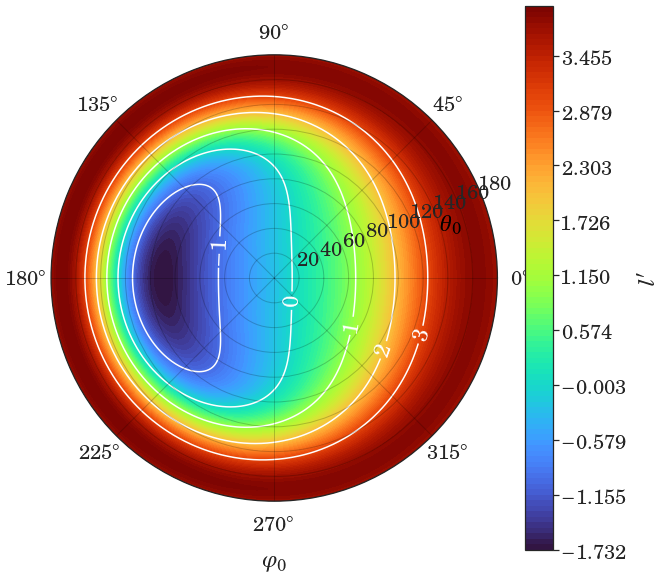

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

msevn.configure_mpl()

drel = 2
h = 1

theta = np.linspace(0, 180, 180)
phi = np.linspace(0, 360, 180)

l_prime = np.array([[calc_l(t, p, drel, h) for p in phi] for t in theta])

levels = np.arange(-10, 10, 1)

phimesh, thetamesh = np.meshgrid(phi * np.pi / 180, theta)

plt.rcParams['contour.negative_linestyle'] = 'solid'
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar='True')
ax.grid(True, alpha=0.2, color='black')

aa = ax.contour(phimesh, thetamesh, l_prime, levels=levels, colors='white', zorder=-1)
ax.clabel(aa, inline=1)
im = ax.contourf(phimesh, thetamesh, l_prime, levels=np.linspace(l_prime.min(), l_prime.max(), 100), cmap='turbo', zorder=-2)

cbar = plt.colorbar(im)

cbar.set_label(r'$l^\prime$', labelpad=10)

#fig.savefig(f'../tex/components/img/celes/phi0_theta0_lprime_d_{drel}l_h_{h}.pdf', bbox_inches='tight')

ax.set_xlabel(r'$\varphi_0$', labelpad=15)
rlab = ax.set_ylabel(r'$\theta_0$', color='black')
rlab.set_position((5, 0.6))
rlab.set_rotation(0)
ax.yaxis.labelpad = -400

ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])
ax.xaxis.set_tick_params(pad=10)




#ax.set_rgrids(range(10, 80, 20), angle=45)
#ax.set_rgrids(range(100, 170, 20), angle=45)
#ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(10, 80, 20)])
#ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in list(range(100, 170, 20))[::-1]])

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

msevn.configure_mpl()

drel = 2
phi0 = 90
#h = 2

dtheta = np.linspace(0, 180, 180)
dphi = np.linspace(0, 360, 180)

def calc_k(t, p, drel, phi0):

    return drel * np.sin(np.pi / 180 * t) * np.sin(np.pi / 180 * (p - phi0))

k_prime = np.array([[calc_k(t, p, drel, phi0) for p in dphi] for t in dtheta])

levels = np.arange(-10, 10, 1)

fig, ax = plt.subplots(figsize=(12, 8))

aa = ax.contour(dphi, dtheta, k_prime, levels, colors='white')
ax.clabel(aa, inline=1)
im = ax.imshow(k_prime, extent=[dphi[0], dphi[-1], dtheta[0], dtheta[-1]], origin='lower', aspect=2, cmap='turbo')

cbar = plt.colorbar(im)

ax.set_ylabel(r'$\Delta \theta$, $^{\circ}$', labelpad=15)
ax.set_xlabel(r'$\Delta \varphi$, $^{\circ}$', labelpad=15)
cbar.set_label(r'$k^\prime$', labelpad=10)

#fig.savefig(f'../tex/components/img/celes/dphi_dtheta_kprime_d_{drel}l_phi0_{phi0}.pdf', bbox_inches='tight')

/tmp/ipykernel_10678/406101708.py:61: UserWarning: The following kwargs were not used by contour: 'label'
  aa = ax.contour(dphimesh, dthetamesh, h_prime, levels, colors=colors[0], label=r'$h^\prime$')
/tmp/ipykernel_10678/406101708.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])


[Text(0, 10, '$10^{\\circ}$'),
 Text(0, 30, '$30^{\\circ}$'),
 Text(0, 50, '$50^{\\circ}$'),
 Text(0, 70, '$70^{\\circ}$')]

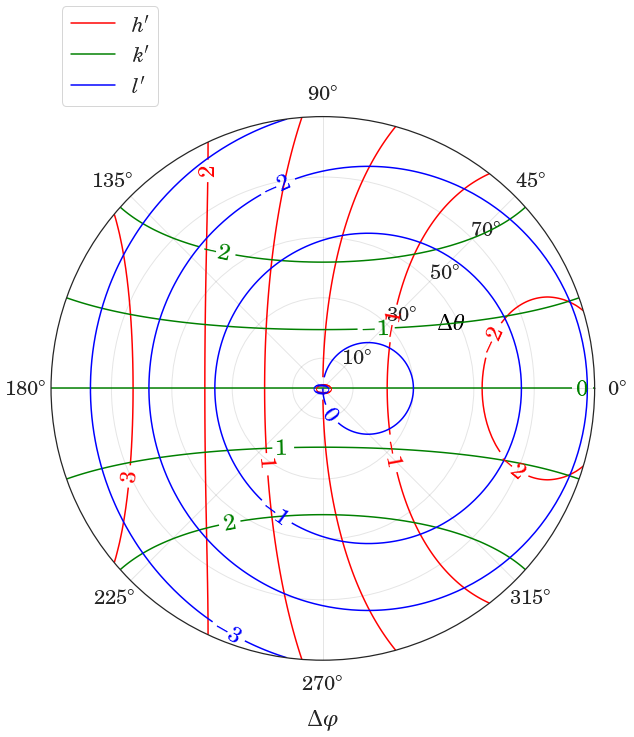

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

msevn.configure_mpl()

drel = 3
phi0 = 180
theta0 = 15
#h = 2

dtheta = np.linspace(0, 90, 180)
dphi = np.linspace(0, 360, 180)

def calc_h(t, p, drel, phi0, theta0):

    fterm = np.cos(np.pi / 180 * theta0) * np.sin(np.pi / 180 * t) * np.cos(np.pi / 180 * (p - phi0))

    sterm = np.sin(np.pi / 180 * theta0) * (np.cos(np.pi / 180 * t) - 1)

    return drel * (fterm - sterm)

def calc_l(t, p, drel, theta0):

    fterm = np.sin(np.pi / 180 * theta0) * np.sin(np.pi / 180 * t) * np.cos(np.pi / 180 * p)

    sterm = np.cos(np.pi / 180 * theta0) * (np.cos(np.pi / 180 * t) - 1)

    return drel * (fterm + sterm)

def calc_k(t, p, drel, phi0):

    return drel * np.sin(np.pi / 180 * t) * np.sin(np.pi / 180 * (p - phi0))


# 270 - t only for theta from 180 to 90 (to reverse polar plot)
h_prime = np.array([[calc_h(t, p, drel, phi0, theta0) for p in dphi] for t in dtheta])
k_prime = np.array([[calc_k(t, p, drel, phi0) for p in dphi] for t in dtheta])
l_prime = np.array([[calc_l(t, p, drel, theta0) for p in dphi] for t in dtheta])

h_prime = np.round(h_prime, 8)
k_prime = np.round(k_prime, 8)
l_prime = np.round(l_prime, 8)

dphimesh, dthetamesh = np.meshgrid(dphi * np.pi / 180, dtheta)

levels = np.arange(-6, 5, 1)

#fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['contour.negative_linestyle'] = 'solid'
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar='True')
ax.grid(True, alpha=0.1, color='black')

#colors = mis.default_palette[:3:-1]
colors = ['red', 'green', 'blue']


aa = ax.contour(dphimesh, dthetamesh, h_prime, levels, colors=colors[0], label=r'$h^\prime$')
aa2 = ax.contour(dphimesh, dthetamesh, k_prime, levels, colors=colors[1])
aa3 = ax.contour(dphimesh, dthetamesh, l_prime, levels, colors=colors[2])

ax.clabel(aa, inline=1)
ax.clabel(aa2, inline=1)
ax.clabel(aa3, inline=1)

lines = [Line2D([0], [0], color=c) for c in colors]
labels = [r'$h^\prime$', r'$k^\prime$', r'$l^\prime$']
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0, 1, 1, 0))

#im = ax.imshow(l_prime, extent=[dphi[0], dphi[-1], dtheta[0], dtheta[-1]], origin='lower', aspect=2, cmap='turbo')

#cbar = plt.colorbar(im)

ax.set_xlabel(r'$\Delta \varphi$', labelpad=15)
rlab = ax.set_ylabel(r'$\Delta \theta$', color='black')
rlab.set_position((5, 0.6))
rlab.set_rotation(0)
ax.yaxis.labelpad = -400

ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])
ax.xaxis.set_tick_params(pad=10)
ax.set_rgrids(range(10, 80, 20), angle=45)
#ax.set_rgrids(range(100, 170, 20), angle=45)
#ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in list(range(100, 170, 20))[::-1]])
ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(10, 80, 20)])

#fig.savefig(f'../tex/components/img/celes/dphi_dtheta_kprime_d_{drel}l_phi0_{phi0}_theta0_{theta0}.pdf', bbox_inches='tight')

#fig.savefig(f'../tex/components/img/celes/dphi_dtheta_kprime_d_{drel}l_phi0_{phi0}_theta0_{theta0}_refr.pdf', bbox_inches='tight')

In [ ]:
from scipy.optimize import newton

aa = newton(lambda x: calc_l(x, p=10, drel=2, theta0=20), 40)

safas = np.array([calc_l(t, p=10, drel=2, theta0=30) for t in dtheta])
sns.lineplot(x=dtheta, y=safas)

print(aa)

/tmp/ipykernel_10678/3707557117.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  aa = ax.contour(phi0mesh, theta0mesh, h_prime, levels, colors='red', label=r'$h^\prime$')
/tmp/ipykernel_10678/3707557117.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])


[Text(0, 10, '$10^{\\circ}$'),
 Text(0, 30, '$30^{\\circ}$'),
 Text(0, 50, '$50^{\\circ}$'),
 Text(0, 70, '$70^{\\circ}$')]

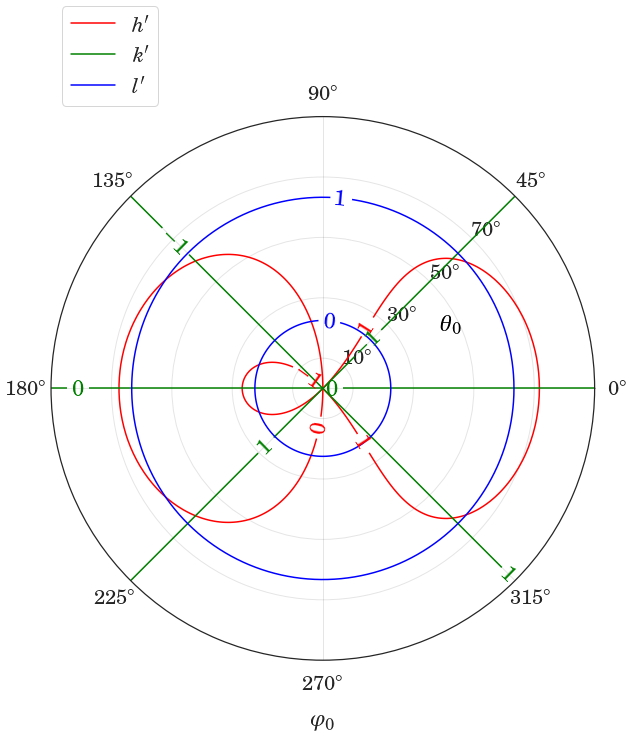

In [25]:
drel = 2
phi0 = np.linspace(0, 360, 180)
theta0 = np.linspace(0, 90, 180)

dtheta = 45
dphi = 0

# 270 - t only for theta from 180 to 90 (to reverse polar plot)
h_prime = np.array([[calc_h(dtheta, dphi, drel, p0, t0) for p0 in phi0] for t0 in theta0])
k_prime = np.array([[calc_k(dtheta, dphi, drel, p0) for p0 in phi0] for t0 in theta0])
l_prime = np.array([[calc_l(dtheta, dphi, drel, t0) for p0 in phi0] for t0 in theta0])

h_prime = np.round(h_prime, 12)
k_prime = np.round(k_prime, 12)
l_prime = np.round(l_prime, 12)

phi0mesh, theta0mesh = np.meshgrid(phi0 * np.pi / 180, theta0)

levels = np.arange(-3, 3, 1)

#fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['contour.negative_linestyle'] = 'solid'
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar='True')
ax.grid(True, alpha=0.1, color='black')

aa = ax.contour(phi0mesh, theta0mesh, h_prime, levels, colors='red', label=r'$h^\prime$')
aa2 = ax.contour(phi0mesh, theta0mesh, k_prime, levels, colors='green')
aa3 = ax.contour(phi0mesh, theta0mesh, l_prime, levels, colors='blue')

ax.clabel(aa, inline=1)
ax.clabel(aa2, inline=1)
ax.clabel(aa3, inline=1)

colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = [r'$h^\prime$', r'$k^\prime$', r'$l^\prime$']
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0, 1, 1, 0))

#im = ax.imshow(l_prime, extent=[dphi[0], dphi[-1], dtheta[0], dtheta[-1]], origin='lower', aspect=2, cmap='turbo')

#cbar = plt.colorbar(im)

ax.set_xlabel(r'$\varphi_0$', labelpad=15)
rlab = ax.set_ylabel(r'$\theta_0$', color='black')
rlab.set_position((5, 0.6))
rlab.set_rotation(0)
ax.yaxis.labelpad = -400

ax.set_xticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(0, 360, 45)])
ax.xaxis.set_tick_params(pad=10)
#ax.set_rgrids(range(10, 80, 20), angle=45)
ax.set_rgrids(range(10, 80, 20), angle=45)
ax.set_yticklabels([r'$' + str(i) + r'^{\circ}$' for i in range(10, 80, 20)])


In [36]:
calc_l(dtheta, dphi, drel, 63.3)

1.0002129580520143